<h2> Filter-Based Feature Selection

<h3> Database

In [3]:
import pandas as pd
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt

In [4]:
ds = pd.read_csv("drebin.csv", low_memory=False)

In [5]:
ds.head()


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
1,0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,0,0,0,0
4,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2> Training Data

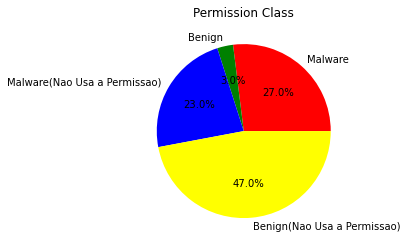

Total de Permissoes:  11120
2999
329
2561
5231


In [6]:
def gpc(class_name, validator):
    count = 0
    j = 0
    if validator == 0:
        for i in ds[class_name]:
            if i == 1 and ds["class"][j] == 1:
                count += 1
            j += 1
        return count
    if validator == 1:
        for i in ds[class_name]:
            if i == 1 and ds["class"][j] == 0:
                count += 1
            j += 1
        return count
    if validator == 2:
        for i in ds[class_name]:
            if i == 0 and ds["class"][j] == 1:
                count += 1
            j += 1
        return count
    if validator == 3:
        for i in ds[class_name]:
            if i == 0 and ds["class"][j] == 0:
                count += 1
            j += 1
        return count
    if validator == 4:
        return len(ds[class_name])

def show_graph(class_name):
    permission_class = [gpc(class_name, 0), gpc(class_name, 1), gpc(class_name, 2), gpc(class_name, 3)]
    labels = ["Malware", "Benign", "Malware(Nao Usa a Permissao)", "Benign(Nao Usa a Permissao)"]
    colors = ["red", "green", "blue", "yellow"]
    plt.pie(permission_class, labels=labels, colors=colors, autopct="%1.1f%%")
    plt.title("Permission Class")
    plt.show()

show_graph("SEND_SMS")
print("Total de Permissoes: ", gpc("SEND_SMS", 4))
print(gpc("SEND_SMS", 0))
print(gpc("SEND_SMS", 1))
print(gpc("SEND_SMS", 2))
print(gpc("SEND_SMS", 3))


<h3> Odds ratio

In [7]:
def od(class_name):
    return (gpc(class_name, 0) + gpc(class_name, 3)) / (gpc(class_name, 1) + gpc(class_name, 2))

od_df = pd.DataFrame(columns=["permission", "od"])
for i in ds.columns:
    if i != "class":
        od_df = pd.concat([od_df, pd.DataFrame([[i, od(i)]], columns=["permission", "od"])])

od_df.sort_values(by="od", ascending=False).head(10)

,permission,od
0,SEND_SMS,2.847751
0,READ_PHONE_STATE,2.375835
0,android.telephony.SmsManager,2.072672
0,android.intent.action.BOOT_COMPLETED,1.953519
0,RECEIVE_SMS,1.920935
0,READ_SMS,1.865241
0,TelephonyManager.getLine1Number,1.749753
0,TelephonyManager.getSubscriberId,1.518686
0,TelephonyManager.getDeviceId,1.451499
0,WRITE_SMS,1.429008


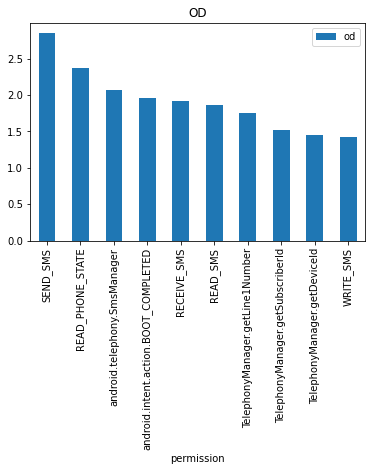

In [8]:
def show_od_graph():
    od_df.sort_values(by="od", ascending=False, inplace=True)
    od_df.head(10).plot(x="permission", y="od", kind="bar")
    plt.title("OD")
    plt.show()

show_od_graph()


<h3> Chi-Square

In [9]:
def chi_squared(class_name):
    a = gpc(class_name, 0)
    b = gpc(class_name, 1)
    c = gpc(class_name, 2)
    d = gpc(class_name, 3)
    return ((a*d - b*c)**2) / ((a+b)*(c+d)*(a+c)*(b+d))

chi_squared_df = pd.DataFrame(columns=["permission", "chi_squared"])
for i in ds.columns:
    if i != "class":
        chi_squared_df = pd.concat([chi_squared_df, pd.DataFrame([[i, chi_squared(i)]], columns=["permission", "chi_squared"])])
chi_squared_df.sort_values(by="chi_squared", ascending=False).head(10)

,permission,chi_squared
0,transact,0.368337
0,onServiceConnected,0.353343
0,bindService,0.3518
0,ServiceConnection,0.349351
0,attachInterface,0.345661
0,android.os.Binder,0.332772
0,SEND_SMS,0.27491
0,Ljava.lang.Class.getCanonicalName,0.258042
0,Ljava.lang.Class.cast,0.234169
0,Ljava.lang.Class.getMethods,0.23044


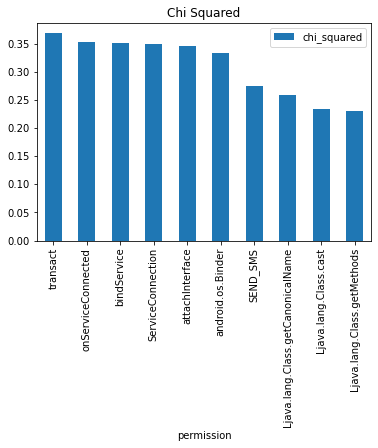

In [10]:
def show_chi_squared_graph():
    chi_squared_df.sort_values(by="chi_squared", ascending=False, inplace=True)
    chi_squared_df.head(10).plot(x="permission", y="chi_squared", kind="bar")
    plt.title("Chi Squared")
    plt.show()

show_chi_squared_graph()